# Almgren-Chriss Optimal Execution - Dynamic Programming

## Syllabus

1. Almgren-Chriss framework
2. Dynamic programming
3. Vanilla implementation
4. From market orders to limit orders

## 1. Almgren-Chriss framework

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to:

- Estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders (but has not seen as much interest from statisticians, economists and econophysicists in the past decades);
- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. KKT nonlinear optimization, dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 2 approaches to solve the Almgren-Chriss model:

- Quadratic Programming (original method by Almgren-Chriss)
- Dynamic Programming

This notebook will focus on the **dynamic programming** approach.


## 2. Dynamic programming

### 2.1. Market impact functions

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

- Temporary market impact:

$$ h(x) = \eta \, x^{\alpha} $$

- *Permanent market impact*:

$$ g(x) = \gamma \, v^{\beta} $$

- *Hamiltonian*

$$ H(x,n) = \psi n g \left(\frac{n}{\tau}\right) + \psi (x-n) \tau h \left(\frac{n}{\tau}\right) + \frac{1}{2} \psi^2 (x-n)^2 \sigma^2 \tau $$

In [2]:
# Utilities
def h(x, alpha, eta):
    return eta * x ** (alpha)

def g(x, beta, gamma):
    return gamma * x ** (beta)

def H(x,n,psi,alpha,beta,gamma,eta,sigma=0.3,tau=0.5):
    """
    Hamiltonian equation. To be minimized through dynamic programming.
    """
    res = psi*n*g(n/tau,beta,gamma) + psi*(x-n)*tau*h(n/tau,alpha,eta) + 0.5*(psi**2)*(sigma**2)*tau*((x-n)**2)
    return res

### 2.2. Dynamic programming: a simplified version

Bellman equation with change of variable (made in our to solve the curse of dimensionality):

- **Terminal condition**

$$ u(x,T-1) = \exp \left[\psi x g \left(\frac{x}{\tau} \right) \right] $$

- **Backward induction**

$$ u(x,t) = \min_{0<n<x} u(x-n,t+1) \, \exp \left[\psi n g \left(\frac{n}{\tau}\right) + \psi (x-n) \tau h \left(\frac{n}{\tau}\right) + \frac{1}{2} \psi^2 (x-n)^2 \sigma^2 \tau \right] $$

Python implementation:

In [3]:
def dynamic_programming(nb_T, X_total, psi, alpha, beta, gamma, eta, plot='True'):
    
    """
    MODEL
    - Bellman equation and value iteration for solving the Markov
      Decision Process of the Almgren-Chriss model.
    
    INPUTS
    - nb_T,       number of time steps
    - X_total,    number of shares to be liquidated
    - psi,        risk aversion
    """
    
    ### Initialization
    u = np.zeros(shape=(nb_T, X_total+1), dtype="float64")      # value function
    b = np.zeros(shape=(nb_T, X_total+1), dtype="int")          # best move
    inventoryforX = np.zeros(shape=(nb_T,1), dtype="int")       # evolution of inventory
    inventoryforX[0] = X_total
    N = []                                                      # optimal selling trajectory
    tau = 0.5
    
    ### Market microstructure: volatility, correlation
    ### [insert dynamic volatility data]
    
    ### Terminal condition
    for x in range(X_total+1):
        u[nb_T - 1, x] = np.exp(x * h(x/tau, alpha, eta))
        b[nb_T - 1, x] = x
    
    ### Backwards induction
    for t in range(nb_T-2, -1, -1):
        for x in range(X_total+1):
            
            best_value = u[t+1,0] * np.exp(H(x, x, psi, alpha, beta, gamma, eta))
            best_n = x
            
            for n in range(x):
                # We compute the utility function if we sell n shares
                current_value = u[t+1,x-n] * np.exp(H(x, n, psi, alpha, beta, gamma, eta))
                
                if current_value < best_value:
                    best_value = current_value
                    best_n = n   # nb of shares to liquidate
               
            u[t,x] = best_value
            b[t,x] = best_n
    
    ### Optimal trajectory
    for t in range(1, nb_T):
        inventoryforX[t] = inventoryforX[t-1] - b[t,inventoryforX[t-1]]
        N.append(b[t,inventoryforX[t-1]])
    
    N = np.asarray(N)
    
    ### Plot results
    if plot=='True':
        plt.figure(figsize=(7,5))
        plt.plot(inventoryforX, color='blue', lw=1.5)
        plt.xlabel('Trading periods')
        plt.ylabel('Number of shares')
        plt.grid(True)
        plt.show()
    
    return u, b, inventoryforX, N

## 3. Vanilla implementation

- $T$, number of trading periods
- $X$, inventory to be liquidated
- $\psi$, risk aversion coefficient
- $\alpha$, power of temporary impact
- $\beta$, power of permanent impact
- $\gamma$, magnitude of permanent impact
- $\eta$, magnitude of temporary impact

Let's do a series of hyperparameter tests:

### 3.1. Parameter $\gamma$

In [10]:
u1, b1, p1, N1 = dynamic_programming(nb_T=50, X_total=1000, psi=0.25, alpha=1, beta=1, gamma=0.05, eta=0.1, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=50, X_total=1000, psi=0.25, alpha=1, beta=1, gamma=0.05, eta=0.01, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=50, X_total=1000, psi=0.25, alpha=1, beta=1, gamma=0.05, eta=0.001, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=50, X_total=1000, psi=0.25, alpha=1, beta=1, gamma=0.05, eta=0.0001, plot='False')
u5, b5, p5, N5 = dynamic_programming(nb_T=50, X_total=1000, psi=0.25, alpha=1, beta=1, gamma=0.05, eta=0.00001, plot='False')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


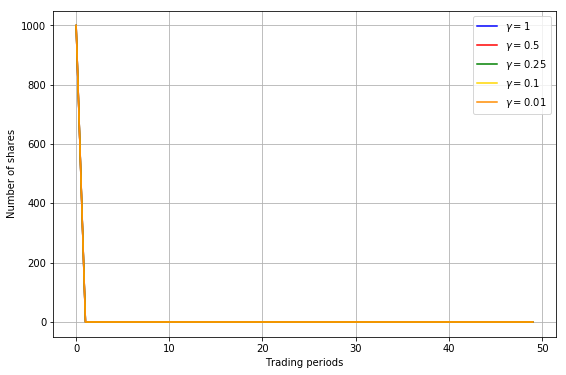

In [11]:
plt.figure(figsize=(9,6))

plt.plot(p1, color='blue', lw=1.5, label='$\gamma=1$')
plt.plot(p2, color='red', lw=1.5, label='$\gamma=0.5$')
plt.plot(p3, color='green', lw=1.5, label='$\gamma=0.25$')
plt.plot(p4, color='gold', lw=1.5, label='$\gamma=0.1$')
plt.plot(p5, color='darkorange', lw=1.5, label='$\gamma=0.01$')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### 3.2. Parameter $\eta$

In [ ]:
u6, b6, p6, N6 = dynamic_programming(nb_T=10, X_total=1000, psi=1, alpha=1, beta=1, gamma=1, eta=1, plot='False')
u7, b7, p7, N7 = dynamic_programming(nb_T=10, X_total=1000, psi=1, alpha=1, beta=1, gamma=1, eta=0.5, plot='False')
u8, b8, p8, N8 = dynamic_programming(nb_T=10, X_total=1000, psi=1, alpha=1, beta=1, gamma=1, eta=0.25, plot='False')
u9, b9, p9, N9 = dynamic_programming(nb_T=10, X_total=1000, psi=1, alpha=1, beta=1, gamma=1, eta=0.1, plot='False')
u10, b10, p10, N10 = dynamic_programming(nb_T=10, X_total=1000, psi=1, alpha=1, beta=1, gamma=1, eta=0.01, plot='False')

### 3.3. Parameter $\psi$

## 4. From market orders to limit orders

Bellman equation with change of variable for the case of limit orders:

- **Terminal condition**

$$ AAA $$

- **Backward induction**

$$ AAA $$